### Import Libraries and Load Data

In [1]:
import os
import csv
import re
import time
from datetime import datetime
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from scipy import stats
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import word_tokenize
from nltk.tokenize import regexp_tokenize
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


from collections import Counter

In [3]:
df=pd.read_csv("project data.csv")
df = df.dropna()

In [4]:
df.isna().any()

author_name            False
handle                 False
tweet_content          False
likes                  False
retweets               False
created_at             False
followers              False
verification_status    False
dtype: bool

In [5]:
df.shape

(15094, 8)

In [6]:
likesdata = pd.read_csv("average_likes.csv")
likesdata.head()

,author_name,average_likes
0,A.R.Rahman,7043.408163
1,Aamir Khan,23027.200000
2,Adrian,1.500000
3,Akshay Kumar,27190.352941
4,Ali Zeck,33.492958


#### Merger to data, add average_likes column to our data

In [7]:
df = pd.merge(left=df, right=likesdata, how='left', left_on='author_name', right_on='author_name')
df = df.dropna()

In [8]:
df.isna().any()

author_name            False
handle                 False
tweet_content          False
likes                  False
retweets               False
created_at             False
followers              False
verification_status    False
average_likes          False
dtype: bool

#### Create New Columns: # of unique hashtags, # of unique handles,  and tweet word count

In [9]:
## new column :count unique hashtags
df['hashtags'] = df.tweet_content.str.findall(r'#.*?(?=\s|$)')
df['hashtags'] = df['hashtags'].apply(lambda x: len(set(x)))

In [10]:
## new column :count unique handle
df['handles'] = df.tweet_content.str.findall(r'@.*?(?=\s|$)')
df['handles'] = df['handles'].apply(lambda x: len(set(x)))

In [11]:
## tweet word count
df["tweet_length"]= df["tweet_content"].str.len() 

#### Text Cleaning

In [12]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['nan', 'http','amp','one','pt','pas','mar','via','yep', 'please','yas'])
df['tweet_content'] = df['tweet_content'].str.replace('http\S+|www.\S+', '', case=False)

In [13]:
clean_text = []
for t in df['tweet_content']:
    words = regexp_tokenize(t.lower(), r'[A-Za-z]+')
    words = [w for w in words if len(w)>2 and w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    clean_text.append(' '.join(words))

In [14]:
df['clean_tweet'] = clean_text

#### Calculate sentiment score

In [15]:
from textblob import TextBlob
df['clean_tweet'] = clean_text
df['sentiment_score'] = df['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

### Exploration

##### 1. Relationship between variables

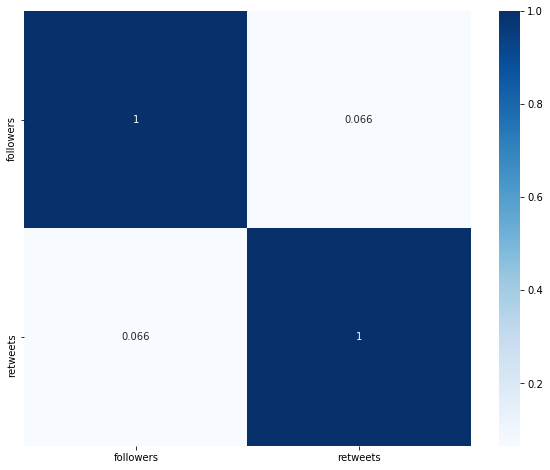

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(df[['followers', 'retweets']].corr(), annot=True, cmap = 'Blues')

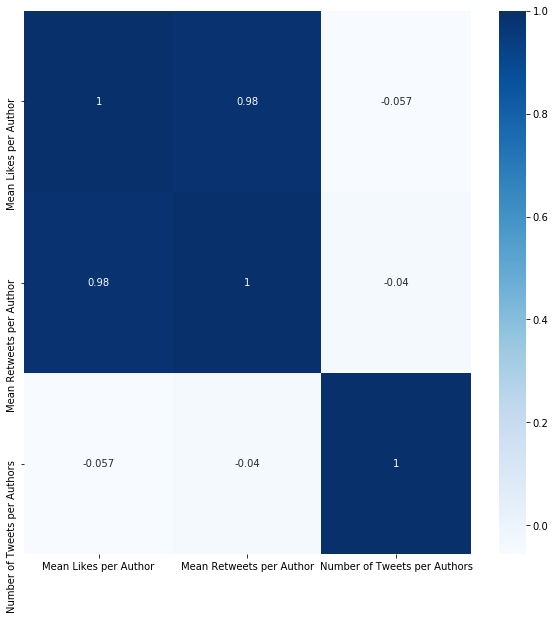

In [17]:
plt.figure(figsize=(10,10))
p  = pd.concat([df.groupby('author_name').likes.mean(), df.groupby('author_name').retweets.mean(), df.groupby('author_name').likes.count()], axis=1 )
p.columns = ['Mean Likes per Author', 'Mean Retweets per Author' ,'Number of Tweets per Authors']
sns.heatmap(p.corr() ,annot=True, cmap = 'Blues')

Negligible Correlation between likes/retweets and number of tweets which came as a surprise. It means your content matter more than the number of tweets. Quality over Quantity.

##### 2. Explore Most Frequently Used N-grams of Words

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [19]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from chart_studio.plotly import iplot
common_words = get_top_n_words(clean_text, 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['clean_tweet' , 'count'])
df1.groupby('clean_tweet').sum()['count'].sort_values(ascending=False).iplot(kind='bar', 
                                                                             yTitle='Count',
                                                                             linecolor='black', 
                                                                             title='Top 20 words')


coronavirus 1002
covid 626
time 527
game 471
year 457
pt 434
new 417
day 397
people 388
today 374
say 348
get 347
first 321
home 316
live 314
mufc 302
ucl 296
tonight 293
back 287
nba 277


In [20]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(clean_text, 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['clean_tweet' , 'count'])
df3.groupby('clean_tweet').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 Bigrams')

covid australia 138
pt reb 121
happy birthday 104
year ago 90
elcl sico 90
reb ast 78
career high 70
narendramodi indiafightscoron 70
new york 69
stay home 66
nba league 66
league pas 65
coronavirus outbreak 62
year deal 62
follow live 60
live update 59
ago today 58
due coronavirus 56
positive coronavirus 55
social distancing 51


In [21]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(clean_text, 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['clean_tweet' , 'count'])
df5.groupby('clean_tweet').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 Trigrams')

pt reb ast 75
nba league pas 64
follow live update 58
year ago today 53
free preview nba 36
preview nba league 36
tested positive coronavirus 35
happy birthday nbabday 35
covid australia covid 32
australia covid australia 32
live watching together 30
watching together nba 30
year deal rapsheet 30
source covid australia 28
covid australia stayathome 28
career high pt 26
goal goal goal 22
streaming live watching 22
elcl sico rmliga 19
rewatch action free 19


### Variable Transfomation

##### 1. likes column

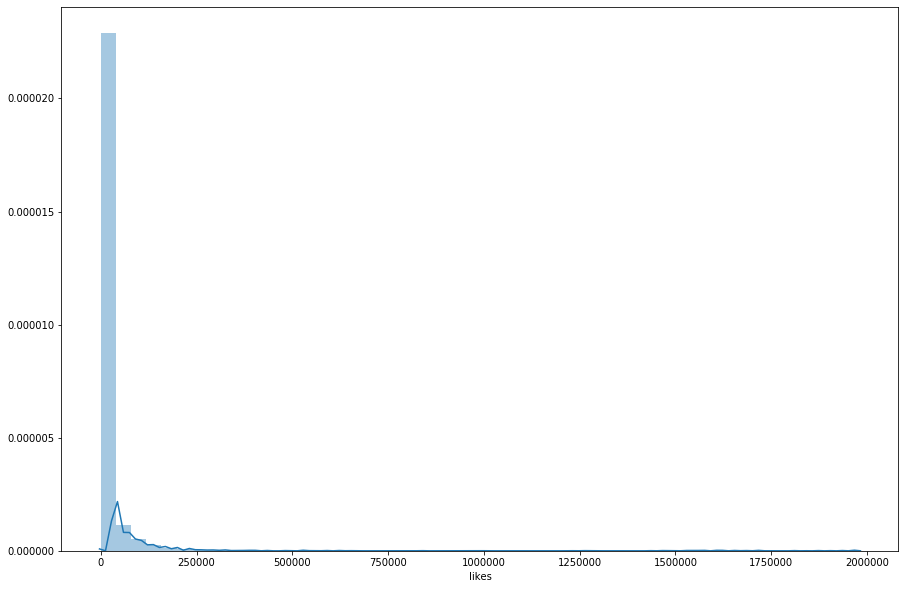

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.distplot(df.likes, ax=ax)

In [23]:
# log10 on likes
df['likes_transformed'] = df['likes'].apply(lambda x: np.log10(x))

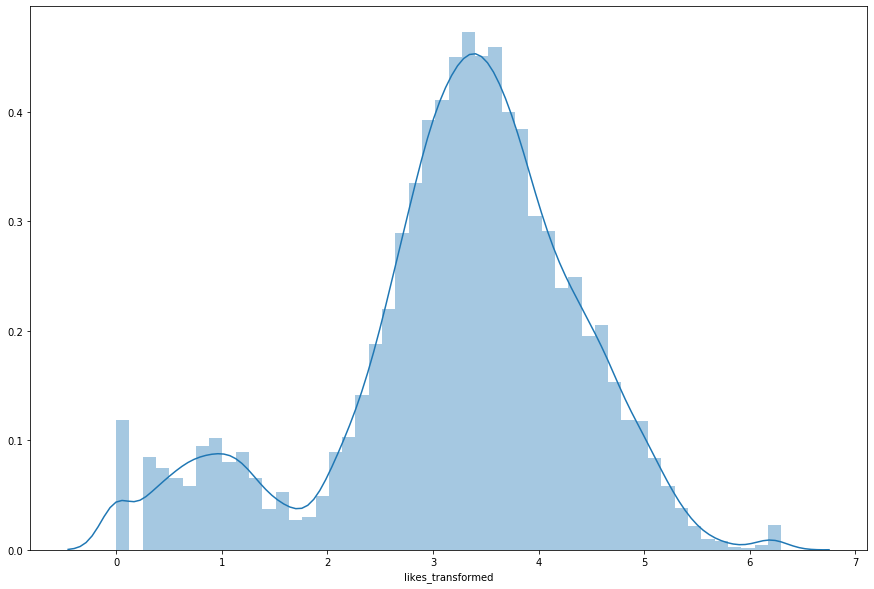

In [24]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.distplot(df.likes_transformed, ax=ax)

##### 2. average_likes column

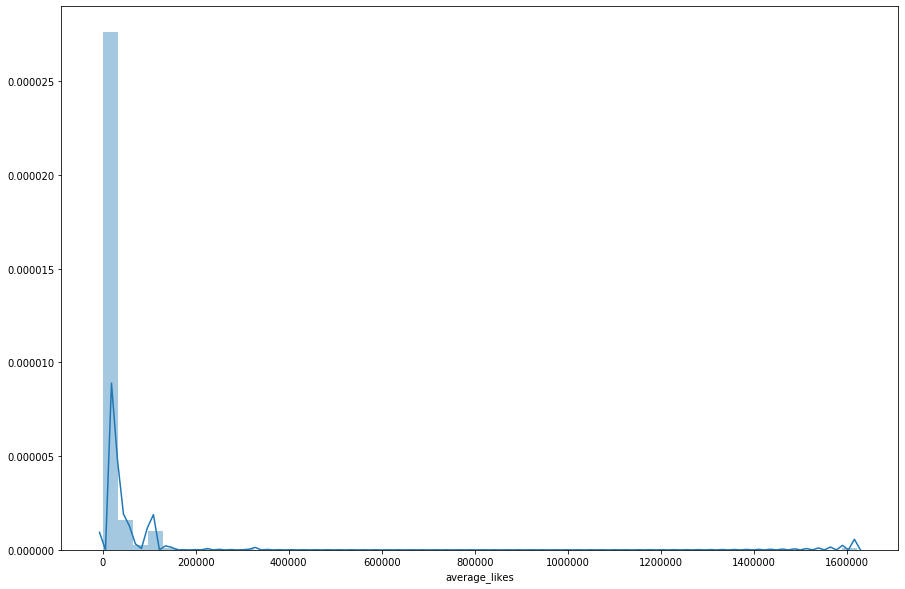

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.distplot(df.average_likes, ax=ax)

In [26]:
# average_likes are highly skewed in the above plot. All numbers are added by 1 to enable a log10 transformation
df['avglikes_tansformed'] = df['average_likes'].apply(lambda x: np.log10(x+1))

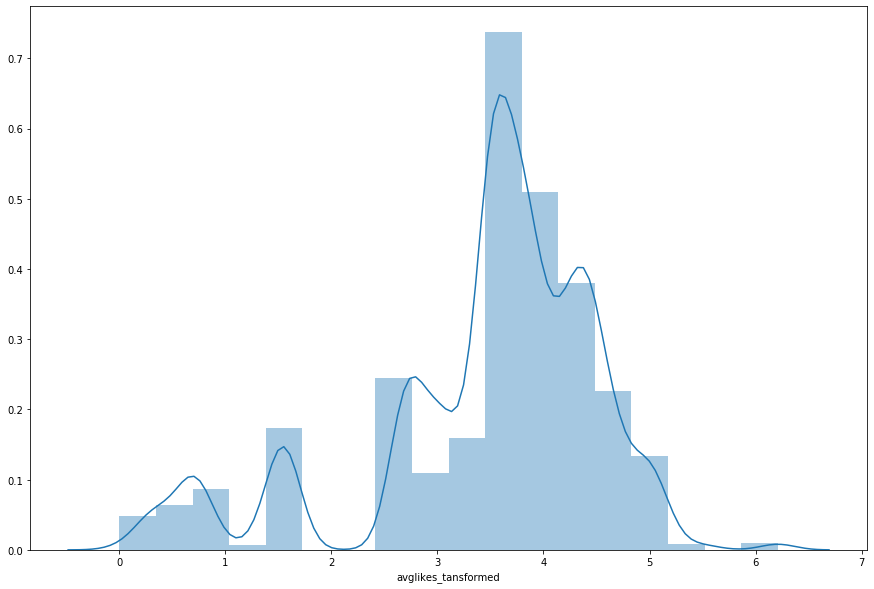

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.distplot(df.avglikes_tansformed, ax=ax, bins = 18)

##### 3. sentiment score column

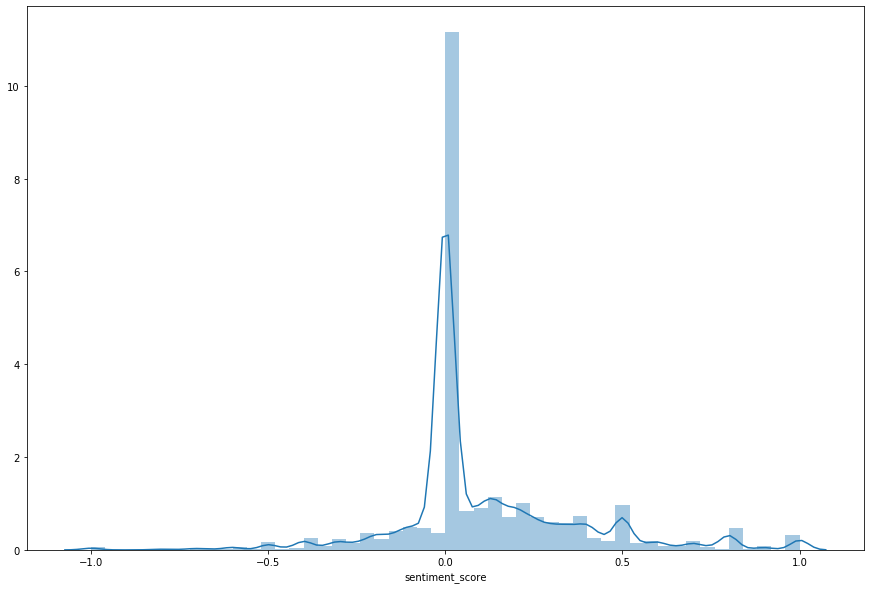

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.distplot(df.sentiment_score, ax=ax)

Most of sentiment scores are center around 0. However, sentiment scores on the two extreme sides could both yeild higher retweet counts. So, a absolute term of sentiment scores could be included in the model

In [29]:
df['sentiment_absolute'] = df['sentiment_score'].abs()

##### 4. retweets column

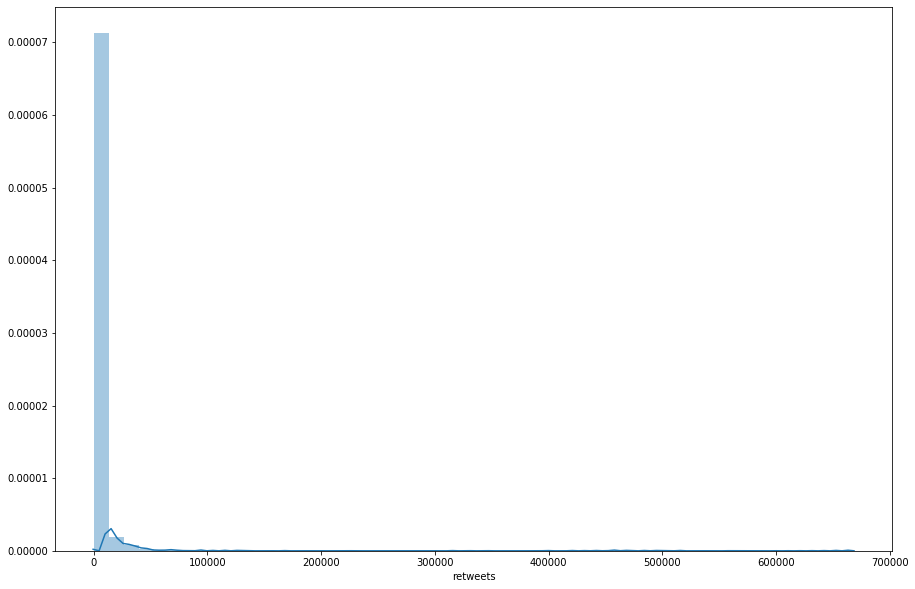

In [30]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.distplot(df.retweets, ax=ax)

In [31]:
# log10 on retweets
df['retweets_tansformed'] = df['retweets'].apply(lambda x: np.log10(x))

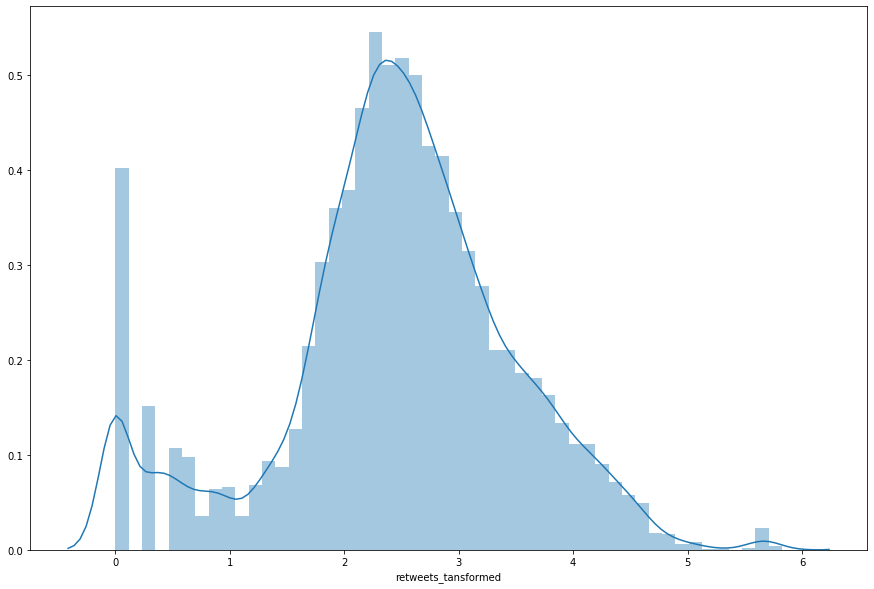

In [32]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.distplot(df.retweets_tansformed, ax=ax)

### Model Construction

##### Model Construction Part is conducted in RStudio, Please refer to the rmarkdown for detailed information

In [ ]:
#df.to_csv('For R 3.csv', index=False)